In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
cci = pd.read_excel("/Users/yena/Desktop/SCH/척척석사/EMR related/kcd7_cci_eci.xlsx") # cci 파일 불러오기
cci = cci.rename(columns = {'표준코드': 'ICD10'})
cci = cci[['ICD10', 'cci_wscore']]
cci = cci.rename({'cci_wscore':'CCI_WSCORE'}, axis=1)
cci = cci.rename({'ICD10':'icd_10'}, axis=1)
cci = cci.drop_duplicates()

#### patient

In [3]:
patient_df = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/(비식별화)부천_낙상환자.xlsx', index_col =0)
patient_df

,낙상발생일시,등록번호,진료과,평가기준일
0,2021-10-05,1167052,감염내과,2021-10-02
1,2021-04-19,1364214,호흡기알레르기내과,2021-04-16
2,2021-03-02,69150,호흡기알레르기내과,2021-02-27
3,2021-02-23,69150,호흡기알레르기내과,2021-02-20
4,2020-12-17,1300117,호흡기알레르기내과,2020-12-14
...,...,...,...,...
215,2018-06-16,1221586,비뇨의학과,2018-06-13
216,2018-03-07,668961,흉부외과,2018-03-04
217,2017-11-04,1157611,신경과,2017-11-01
218,2017-08-17,37112,흉부외과,2017-08-14


In [4]:
patient_list = patient_df['등록번호'].astype(str).unique()
len(patient_list)

206

In [5]:
fall_date = patient_df[['등록번호', '낙상발생일시']]

### 낙상위험도

In [7]:
fall = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/20220304_낙상-1(부천병원).xlsx')
len(fall['등록번호'].unique())

139

In [8]:
fall = fall[fall['등록번호'].astype(str).isin(set(patient_list))]
len(fall['등록번호'].unique())

137

In [10]:
import datetime

def str_to_dt(x):
    x = str(x)
    d = int(x[0:4])
    y = int(x[4:6])
    z = int(x[6:8])
    # hours = int(x[8:10])
    # mins = int(x[10:12])
    # secs = int(x[12:])
    # str_data = (d+','+y+','+z+','+hours+','+mins+','+secs)
    new_time = datetime.datetime(d,y,z)
    new_time_no = new_time.replace(microsecond = 0)
    
    return new_time_no

In [11]:
fall = fall[['등록번호', '도구명', '평가일자', '상세내역명']]


fall = fall.merge(fall_date, on= ['등록번호'])
fall['평가일자'] = fall['평가일자'].apply(str_to_dt)
print(len(fall['등록번호'].unique()))
fall.head(2)

137


,등록번호,도구명,평가일자,상세내역명,낙상발생일시
0,21137,의식/정신상태,2019-02-13,자신의 기능 수준에 대해 잘 알고 있음,2019-02-14
1,21137,걸음걸이/이동,2019-02-13,정상/침상안정/부동,2019-02-14


In [12]:
fall['days'] = fall['낙상발생일시']-fall['평가일자']
print(len(fall['등록번호'].unique()))
cond = ['0 days', '1 days', '2 days', '3 days']
fall = fall[fall['days'].isin(set(cond))]
print(len(fall['등록번호'].unique()))

137
114


In [13]:
### str처리해서 
test_str = fall.copy()
test_str = test_str.astype(str)
test_str['agg'] = test_str['등록번호']+'-'+test_str['도구명']+'-'+test_str['상세내역명']+'-'+test_str['평가일자']+'-'+test_str['낙상발생일시']

In [14]:
fall_history = []
help_list = []
secondary = []
heparin_list = []
mental_list = []
walk_list =[]

format_ = '%Y-%m-%d'

for num, i in enumerate(test_str['등록번호'].tolist()):
       
    ### 낙상경험
    if '지난 3개월간 낙상 경험-없음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        fall_history.append(detail)
    elif '지난 3개월간 낙상 경험-있음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        fall_history.append(detail)
        
    ### 보행보조
    elif '보행보조-보행 불가능(침상안정) 또는 보조기구 없이 보행 가능함' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        help_list.append(detail)
    elif '보행보조-목발/지팡이/보행기 등 보조기구 사용하여 혼자 보행 가능함' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        help_list.append(detail)
    elif '보행보조-혼자 할 수 없음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'2'
        help_list.append(detail)
    
    ### 이차진단    
    elif '이차 진단 (부진단)-없음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        secondary.append(detail)
    elif '이차 진단 (부진단)-있음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        secondary.append(detail)
        
    ### 헤파린
    elif '정맥수액요법/헤파린록(heparin lock)-없음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        heparin_list.append(detail)
    elif '정맥수액요법/헤파린록(heparin lock)-있음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        heparin_list.append(detail)    
    
    ### 약물사용
    # elif  '약물사용-다른 약물 / 해당 없음' in test_str['agg'].tolist()[num]:
    #     detail = test_str['agg'].tolist()[num] +'//'+'0'
    #     drug_history.append(detail)
    # elif  '약물사용-2시간이상 진정제, 수면제, 최면제, 정신안정제, 항불안제, 완화제/이뇨제, 진통제 투여' in test_str['agg'].tolist()[num]:
    #     detail = test_str['agg'].tolist()[num] +'//'+'1'
    #     drug_history.append(detail)
   
    ### 걸음걸이/이동
    elif '걸음걸이/이동-정상/침상안정/부동' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        walk_list.append(detail)
    elif '걸음걸이/이동-허약함' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        walk_list.append(detail)
    elif '걸음걸이/이동-장애가 있음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'2'
        walk_list.append(detail)
        
    ### 의식정신상태
    elif  '의식/정신상태-자신의 기능 수준에 대해 잘 알고 있음' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'0'
        mental_list.append(detail)
    elif '의식/정신상태-자신의 기능수준을 과대평가하거나 잊어버림' in test_str['agg'].tolist()[num]:
        detail = test_str['agg'].tolist()[num] +'//'+'1'
        mental_list.append(detail)
        
    else:
        print(test_str['agg'].tolist()[num])
        

# print(len(new_patient_list))
# print(len(new_date_list))
# print(len(fall_date_list))

print(len(fall_history))
print(len(help_list))
print(len(secondary))
print(len(heparin_list))
print(len(mental_list))
print(len(walk_list))     

21137-평가기준-입원 시-2019-02-13-2019-02-14
21137-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2019-02-14-2019-02-14
35702-평가기준-전입 시-2019-02-24-2019-02-25
39309-평가기준-입원 시-2021-02-04-2021-02-06
39309-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2021-02-06-2021-02-06
59472-평가기준-입원 시-2019-09-16-2019-09-19
59472-평가기준-전입 시-2019-09-18-2019-09-19
60730-평가기준-전입 시-2019-03-27-2019-03-30
60730-평가기준-전입 시-2019-03-27-2019-03-30
60730-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2019-03-30-2019-03-30
60730-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2019-03-30-2019-03-30
60730-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2019-05-31-2019-06-03
60730-평가기준-환자상태변화시(수술/침습적 시술 후, 진정 후, 낙상과 관련된 의약품 투여 후(항고혈압제, 이뇨제, 수면진정제), 낙상발생 시,  발작, 의식변화 등)-2019-05-31-2019-06-03
65175-평가기준-환자상태변화시(수술/침습적 

In [15]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in fall_history:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
fall_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '낙상이력':adl_detail})
print(fall_df.shape)
fall_df.head()

(207, 4)


,등록번호,낙상발생일시,평가일자,낙상이력
0,21137,2019-02-14,2019-02-13,0
1,21137,2019-02-14,2019-02-14,0
2,35702,2019-02-25,2019-02-24,0
3,39309,2021-02-06,2021-02-04,0
4,39309,2021-02-06,2021-02-06,0


In [16]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in help_list:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
help_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '보행보조':adl_detail})
print(help_df.shape)
help_df.head()

(188, 4)


,등록번호,낙상발생일시,평가일자,보행보조
0,21137,2019-02-14,2019-02-13,0
1,21137,2019-02-14,2019-02-14,0
2,35702,2019-02-25,2019-02-24,1
3,39309,2021-02-06,2021-02-04,0
4,39309,2021-02-06,2021-02-06,0


In [17]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in secondary:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
sec_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '이차진료':adl_detail})
print(sec_df.shape)
sec_df.head()

(207, 4)


,등록번호,낙상발생일시,평가일자,이차진료
0,21137,2019-02-14,2019-02-13,1
1,21137,2019-02-14,2019-02-14,1
2,35702,2019-02-25,2019-02-24,1
3,39309,2021-02-06,2021-02-04,1
4,39309,2021-02-06,2021-02-06,1


In [18]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in heparin_list:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
hep_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '헤파린록':adl_detail})
print(hep_df.shape)
hep_df.head()

(207, 4)


,등록번호,낙상발생일시,평가일자,헤파린록
0,21137,2019-02-14,2019-02-13,0
1,21137,2019-02-14,2019-02-14,0
2,35702,2019-02-25,2019-02-24,0
3,39309,2021-02-06,2021-02-04,0
4,39309,2021-02-06,2021-02-06,0


In [19]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in mental_list:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
ment_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '의식정신상태':adl_detail})
print(ment_df.shape)
ment_df.head()

(208, 4)


,등록번호,낙상발생일시,평가일자,의식정신상태
0,21137,2019-02-14,2019-02-13,0
1,21137,2019-02-14,2019-02-14,0
2,35702,2019-02-25,2019-02-24,0
3,39309,2021-02-06,2021-02-04,0
4,39309,2021-02-06,2021-02-06,0


In [20]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in walk_list:
    patient = i.split('-')[0]
    y,m,d = i.split('-')[3:6]
    Y,M,D = i.split('-')[6:]
    D_2 = D.split('//')[0]
    adl_ = D.split('//')[-1]
    val_date =  datetime.datetime.strptime(y+'-'+m+'-'+d, format_)
    fall_date = datetime.datetime.strptime(Y+'-'+M+'-'+D_2, format_)
    
    new_patient_list.append(patient)
    new_date_list.append(val_date)
    fall_date_list.append(fall_date)
    adl_detail.append(adl_)
    
walk_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '걸음/의식':adl_detail})
print(walk_df.shape)
walk_df.head()

(208, 4)


,등록번호,낙상발생일시,평가일자,걸음/의식
0,21137,2019-02-14,2019-02-13,0
1,21137,2019-02-14,2019-02-14,0
2,35702,2019-02-25,2019-02-24,1
3,39309,2021-02-06,2021-02-04,0
4,39309,2021-02-06,2021-02-06,0


In [21]:
final_fall = pd.merge(fall_df.drop_duplicates(), help_df.drop_duplicates(), on=['등록번호','낙상발생일시', '평가일자'], how='inner')
print(final_fall.shape)
# final_fall = pd.merge(final_fall,drug_df , on=['등록번호','낙상발생일시', '평가일자'], how='outer')
# print(final_fall.shape)
final_fall = pd.merge(final_fall.drop_duplicates(),sec_df.drop_duplicates() , on=['등록번호','낙상발생일시', '평가일자'], how='inner')
print(final_fall.shape)
final_fall = pd.merge(final_fall.drop_duplicates(),hep_df.drop_duplicates() , on=['등록번호','낙상발생일시', '평가일자'], how='inner')
# print(final_fall.shape)
final_fall = pd.merge(final_fall.drop_duplicates(), ment_df.drop_duplicates() , on=['등록번호','낙상발생일시', '평가일자'], how='inner')
# print(final_fall.shape)
final_fall = pd.merge(final_fall.drop_duplicates(), walk_df.drop_duplicates() , on=['등록번호','낙상발생일시', '평가일자'], how='inner')
# print(final_fall.shape)
# # final_fall = final_fall.fillna('데이터없음')
print(final_fall.shape)

(160, 5)
(160, 6)
(160, 9)


In [22]:
len(final_fall['등록번호'].unique())

101

In [23]:
final_fall['days'] = final_fall['낙상발생일시']-final_fall['평가일자']
final_fall= final_fall.drop_duplicates()
# final_fall = final_fall.astype(int)

In [24]:
final_fall[['낙상이력', '보행보조', '이차진료', '헤파린록','의식정신상태','걸음/의식']] = final_fall[['낙상이력', '보행보조', '이차진료', '헤파린록','의식정신상태','걸음/의식']].astype(int)
final_fall['MFS'] = (final_fall['헤파린록'] * 20) + (final_fall['이차진료'] * 15) +(final_fall['낙상이력']*25) +(final_fall['걸음/의식']*10) + (final_fall['의식정신상태']*15) + (final_fall['보행보조']*15)
final_fall['MFS'].describe()

count    160.000000
mean      50.375000
std       23.742261
min        0.000000
25%       35.000000
50%       47.500000
75%       60.000000
max      100.000000
Name: MFS, dtype: float64

In [25]:
final_fall.head()

,등록번호,낙상발생일시,평가일자,낙상이력,보행보조,이차진료,헤파린록,의식정신상태,걸음/의식,days,MFS
0,21137,2019-02-14,2019-02-13,0,0,1,0,0,0,1 days,15
1,21137,2019-02-14,2019-02-14,0,0,1,0,0,0,0 days,15
2,35702,2019-02-25,2019-02-24,0,1,1,0,0,1,1 days,40
3,39309,2021-02-06,2021-02-04,0,0,1,0,0,0,2 days,15
4,39309,2021-02-06,2021-02-06,0,0,1,0,0,0,0 days,15


In [26]:
final_fall.to_csv('[1112]낙상위험도평가_MFS_부천.csv')

In [27]:
final_fall

,등록번호,낙상발생일시,평가일자,낙상이력,보행보조,이차진료,헤파린록,의식정신상태,걸음/의식,days,MFS
0,21137,2019-02-14,2019-02-13,0,0,1,0,0,0,1 days,15
1,21137,2019-02-14,2019-02-14,0,0,1,0,0,0,0 days,15
2,35702,2019-02-25,2019-02-24,0,1,1,0,0,1,1 days,40
3,39309,2021-02-06,2021-02-04,0,0,1,0,0,0,2 days,15
4,39309,2021-02-06,2021-02-06,0,0,1,0,0,0,0 days,15
...,...,...,...,...,...,...,...,...,...,...,...
155,1361608,2021-05-27,2021-05-27,0,1,1,1,0,1,0 days,60
156,1363535,2021-04-12,2021-04-09,0,1,0,1,0,1,3 days,45
157,1363535,2021-04-12,2021-04-10,0,1,0,1,0,1,2 days,45
158,1364214,2021-04-19,2021-04-19,0,1,1,0,0,1,0 days,40


#### 약물

In [28]:
pat_drug_ = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/낙상환자 약물치료 자료(부천) (1).xlsx')
atc_org_ = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/ATC_cluster.xlsx') # 파일 확장자 다름 --> 같은 파일인지 모르겟싐 일단 ㄱ

In [29]:
atc_drug = pat_drug_[['등록번호','낙상일자', '낙상일자에서의 이전일자', 'ATC분류코드']] # 컬럼명 달랐싐
atc_drug['낙상발생일시'] = atc_drug['낙상일자'].apply(str_to_dt)
atc_drug['평가일자'] = atc_drug['낙상일자에서의 이전일자'].apply(str_to_dt)

In [30]:
atc_drug['유무'] = atc_drug['낙상발생일시']-atc_drug['평가일자']    # 날짜 빼고
atc_drug['유무'] = atc_drug['유무'].astype(str) # str 로 변환
atc_drug.head(5)

,등록번호,낙상일자,낙상일자에서의 이전일자,ATC분류코드,낙상발생일시,평가일자,유무
0,21137,20190214,20190213,B01AB05,2019-02-14,2019-02-13,1 days
1,21137,20190214,20190213,C03CA01,2019-02-14,2019-02-13,1 days
2,21137,20190214,20190213,B01AA03,2019-02-14,2019-02-13,1 days
3,21137,20190214,20190214,C03CA01,2019-02-14,2019-02-14,0 days
4,21137,20190214,20190214,C03DA01,2019-02-14,2019-02-14,0 days


In [31]:
cond = ['0 days', '1 days', '2 days', '3 days'] 
atc_drug['유무'] = atc_drug['유무'].astype(str) # 한번 더 변환
atc_drug = atc_drug[atc_drug['유무'].isin(set(cond))]  

len(atc_drug['등록번호'].unique())

176

In [32]:
atc_drug = atc_drug.merge(atc_org_, on = ['ATC분류코드']).drop_duplicates()
atc_drug = atc_drug.astype(str)
atc_drug = atc_drug[atc_drug['등록번호'].isin(set(patient_list))]
len(atc_drug['등록번호'].unique())

174

In [33]:
# atc_drug = atc_drug.drop(columns=['no']).drop_duplicates()
atc_drug['Cluster_c'] = atc_drug['Cluster']

In [34]:
atc_test = pd.DataFrame(atc_drug.groupby(['등록번호', '낙상발생일시', '평가일자', '유무', 'Cluster'])['Cluster_c'].count()).reset_index().drop_duplicates()

In [36]:
atc_test.to_csv('[1112]부천_약물.csv')

In [38]:
pd.DataFrame(atc_test.groupby(['유무', 'Cluster'])['Cluster_c'].sum()).reset_index().drop_duplicates().to_csv('[1112]drug_EDA.csv')

In [39]:
eda_drug = pd.DataFrame(atc_test.groupby(['유무', 'Cluster'])['Cluster_c'].sum()).reset_index().drop_duplicates()
eda_drug['Cluster_c'] = eda_drug['Cluster_c'].astype(int)
eda_drug

,유무,Cluster,Cluster_c
0,0 days,A,14
1,0 days,B,78
2,0 days,C,138
3,0 days,D,40
4,0 days,E,62
...,...,...,...
79,3 days,Q,8
80,3 days,R,41
81,3 days,S,276
82,3 days,T,19


In [40]:
### 수면제에 유의미한 내용 없는 듯, 오히려 마약류?
cond = ['P','J', 'K','C']
eda_drug[eda_drug['Cluster'].isin(set(cond))]

,유무,Cluster,Cluster_c
2,0 days,C,138
9,0 days,J,21
10,0 days,K,19
15,0 days,P,17
23,1 days,C,135
30,1 days,J,22
31,1 days,K,22
36,1 days,P,17
44,2 days,C,125
51,2 days,J,20


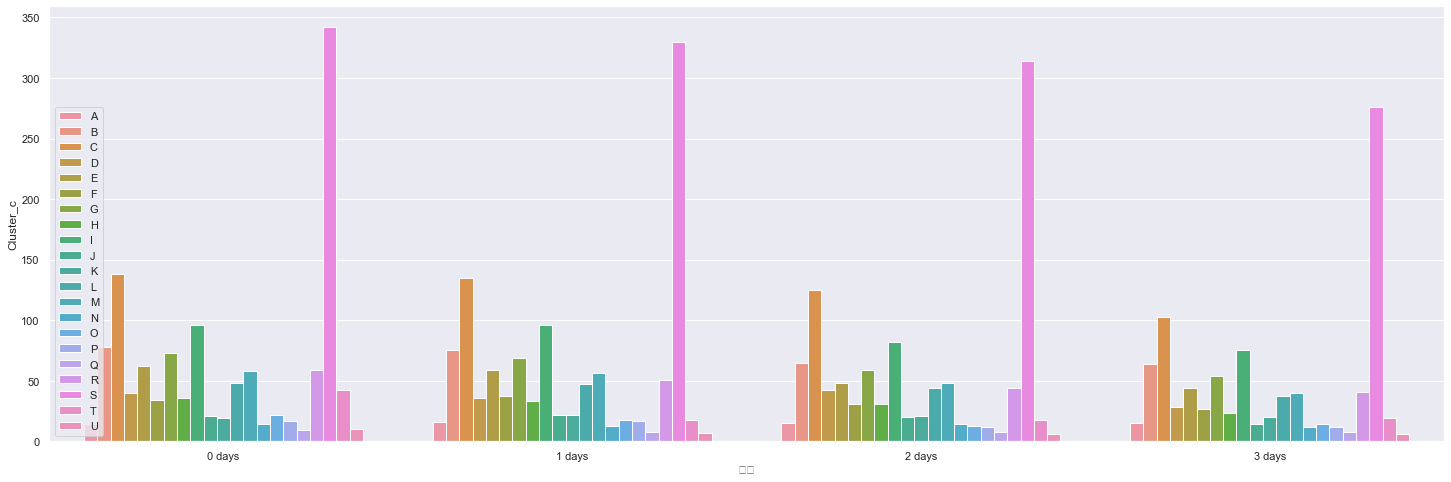

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(25,8)})
sns.barplot(x = eda_drug['유무'], y = eda_drug['Cluster_c'], hue = eda_drug['Cluster'])

plt.legend(loc='lower left')

In [42]:
atc_drug= pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]부천_약물.csv', index_col=0)
atc_drug

,등록번호,낙상발생일시,평가일자,유무,Cluster,Cluster_c
0,1009953,2018-11-17,2018-11-14,3 days,B,1
1,1009953,2018-11-17,2018-11-14,3 days,F,1
2,1009953,2018-11-17,2018-11-14,3 days,I,1
3,1009953,2018-11-17,2018-11-14,3 days,R,1
4,1009953,2018-11-17,2018-11-14,3 days,S,5
...,...,...,...,...,...,...
2852,980831,2018-09-28,2018-09-28,0 days,C,3
2853,980831,2018-09-28,2018-09-28,0 days,D,1
2854,980831,2018-09-28,2018-09-28,0 days,F,1
2855,980831,2018-09-28,2018-09-28,0 days,G,1


### 간호필요도

In [55]:
needs = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/(비식별화)20220512_필요도(부천).xlsx')

In [56]:
len(needs['등록번호'].unique())

139

In [57]:
needs = needs[['등록번호', '도구명', '상세내역명', '평가일자']]
needs['등록번호'] = needs['등록번호'].astype(str)
needs = needs[needs['등록번호'].isin(set(patient_list))]
needs['평가일자'] = needs['평가일자'].apply(str_to_dt)
print(needs.shape)
print(len(needs['등록번호'].unique()))
needs.head(3)

(143788, 4)
139


,등록번호,도구명,상세내역명,평가일자
0,31019,계속적인 감시,감시 없음,2017-01-08
1,31019,산소포화도 측정,측정안함,2017-01-08
2,31019,흡인간호(기관 내),해당없음,2017-01-08


In [58]:
fall_date = patient_df[['등록번호', '낙상발생일시']]   

In [59]:
needs['도구명'] = needs['도구명'].replace({'ADL_배변':'ADL_배뇨, 배변'})
needs['도구명'] = needs['도구명'].replace({'흡인간호(기관 내)':'호흡 간호_비침습적 산소 투여'})
needs['도구명'] = needs['도구명'].replace({'ADL_이동':'ADL_침상 밖으로 이동'})

tools=['ADL_배뇨, 배변','호흡 간호_비침습적 산소 투여', 'ADL_체위변경', 'ADL_침상 밖으로 이동', 'ADL_식사섭취']
needs = needs[needs['도구명'].isin(set(tools))]

needs= needs.drop_duplicates()
print(needs.shape)
print(len(needs['등록번호'].unique()))

(34235, 4)
139


In [60]:
fall_date['등록번호'] = fall_date['등록번호'].astype(str)
needs = needs.merge(fall_date, on=['등록번호'], how='inner')
print(len(needs['등록번호'].unique()))

139


In [61]:
needs

,등록번호,도구명,상세내역명,평가일자,낙상발생일시
0,31019,호흡 간호_비침습적 산소 투여,해당없음,2017-01-08,2017-07-24
1,31019,ADL_체위변경,"일부도움(침대 난간, 끈, 바, 사이드레일 등을 잡으면 혼자서 침대에서 뒤척임을 할...",2017-01-08,2017-07-24
2,31019,ADL_침상 밖으로 이동,"일부도움(직접 도움을 줄 필요는 없지만 사고 등이 나지 않도록 지켜보는 경우, 들것...",2017-01-08,2017-07-24
3,31019,ADL_식사섭취,"일부도움(필요에 따라 식사 섭취 행위의 일부에 도움을 주는 경우, 식탁에서 먹기 편...",2017-01-08,2017-07-24
4,31019,"ADL_배뇨, 배변",도움없음(배변을 위한 일련의 행위 모두를 스스로 할 수 있는 경우),2017-01-08,2017-07-24
...,...,...,...,...,...
41345,1387194,"ADL_배뇨, 배변",전부 도움(스스로 배변 배뇨를 위한 일련의 행위 모두를 전혀 할 수 없어 간호 직원...,2021-09-11,2021-09-09
41346,1387194,ADL_체위변경,"도움없음(도움 없이 스스로 변경 가능, 한쪽으로만 변경이 가능해도 됨, 침대 난간,...",2021-09-11,2021-09-09
41347,1387194,ADL_침상 밖으로 이동,"도움 없음(도움 없이 스스로 침상 밖으로 이동이 가능, 무언가 잡거나 보조기구를 이...",2021-09-11,2021-09-09
41348,1387194,ADL_식사섭취,"도움 없음(도움, 관찰 없이 스스로 식사 가능한 경우, 보조기구 이용 스스로 식사 ...",2021-09-11,2021-09-09


In [62]:
needs['유무'] = needs['낙상발생일시']-needs['평가일자']
needs['유무'] = needs['유무'].astype(str)
cond = ['0 days', '1 days', '2 days', '3 days']
needs = needs[needs['유무'].isin(set(cond))]
print(len(needs['등록번호'].unique()))


102


In [63]:
needs['유무'].value_counts()

0 days    530
1 days    525
2 days    460
3 days    410
Name: 유무, dtype: int64

In [64]:
test = needs.copy()
test['agg'] = test['등록번호'].astype(str)+'_'+ test['평가일자'].astype(str)+'_'+test['상세내역명']

In [66]:

from tqdm import tqdm   # 작업 진행률 표시

In [67]:
ADL_uri = []
ADL_resp = []
ADL_pos = []
ADL_outbed =[]
ADL_meal=[]
new_patient_list = []
new_date_list = []

for num, i in tqdm(enumerate(test['agg'].tolist())):
    patient = i.split('_')[0]
    new_patient_list.append(patient)
    date = i.split('_')[1]
    new_date_list.append(date)
    detail = i.split('_')[2]
  
    ## 배뇨배변 ###
    if detail =="도움 없음(도움 없이 배변, 배뇨를 위한 일련의 행위, 장루관리를 스스로 할 수 있는 경우, 관장하는 경우)":
        detail_input = patient+'_'+date+'_'+'0'
        ADL_uri.append(detail_input)
    elif detail =="도움없음(배변을 위한 일련의 행위 모두를 스스로 할 수 있는 경우)":
        detail_input = patient+'_'+date+'_'+'0'
        ADL_uri.append(detail_input)
    elif detail == '일부 도움(도움 없이 배변, 배뇨를 위한 일련의 행위를 하는데 어려움이 있어 간호직원 등의 일부 도움이 반드시 필요한 경우,  정서장애, 인지장애, 혈압조절장애 등으로 인하여 배변, 배뇨를 하는 동안 반드시 누군가 곁에서 관찰, 감독이 필요한 경우, Foley-catheter 적용중인 경우)(nelaton catheter제외)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_uri.append(detail_input)
    elif detail == '일부도움(배변을 위한 일련의 행위에 일부 도움이 행해지는 경우)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_uri.append(detail_input)
    elif detail =='전부 도움(스스로 배변 배뇨를 위한 일련의 행위 모두를 전혀 할 수 없어 간호 직원 등에 의해 전적인 도움 필요, 기저귀 착용,장루관리를 간호직원이 하는 경우)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_uri.append(detail_input)
    elif detail =='전부도움(배변을 위한 일련의 행위에 전부 도움이 행해지는 경우, 활동에 제한이 있어 기저귀를 적용한 환자 모두 포함)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_uri.append(detail_input)

    ### 식사섭취###
    if detail == '도움 없음(도움, 관찰 없이 스스로 식사 가능한 경우, 보조기구 이용 스스로 식사 가능한 경우, NPO, TPN 등의 사유로 식사하는 행위가 미발생 하는 경우)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_meal.append(detail_input)
    elif detail == '도움없음(도움, 지켜보는 것 없이 스스로 식사를 할 수 있는 경우, 젓가락, 숟가락 이외의 다른 보조기구등을 사용하는 경우, 식사중지, 단식의 경우)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_meal.append(detail_input)
    elif detail == '일부 도움(간단한 식사도구는 스스로 다룰 수 있으나 작게 자르기, 껍질 벗기기, 생선 바르기 등을 스스로 할 수 없어 간호직원 등의 도움이 필요한 경우,  흡인( aspiration) 과거력, 인지장애, 연하곤란(dysphagia) 등으로 인하여 식사하는 동안 반드시 누군가 곁에서 관찰, 감독이 필요한 경우) ':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_meal.append(detail_input)
    elif detail == '일부도움(필요에 따라 식사 섭취 행위의 일부에 도움을 주는 경우, 식탁에서 먹기 편하도록 배려하는 행위가 이루어 지고 있는 경우, 식사 중 한 가지라도 도움을 주는 경우, 지켜보며 지시가 필요한 경우)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_meal.append(detail_input)
    elif detail == '전부 도움(혼자서는 식사를 전혀 할 수 없어 간호직원 등에 의해 모든 과정에서 전적인 도움(스푼 피딩)을 받아야 함)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_meal.append(detail_input)
    elif detail == '전부도움(스스로는 전혀 먹을 수 없고 모든 것에 도움이 필요한 경우, 식사 시작부터 끝까지 모든 도움이 필요한 경우)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_meal.append(detail_input)
         

    ### 체위변경 ###
    if detail =='도움없음(도움 없이 스스로 변경 가능, 한쪽으로만 변경이 가능해도 됨, 침대 난간, 끈, 바, 사이드 레일 등을 사용하는 경우)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_pos.append(detail_input)
    elif detail =='도움없음(침대에서 뒤척임을 환자 스스로 할 수 있는 경우)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_pos.append(detail_input)
    elif detail =='일부 도움(스스로 체위 변경을 하는데 어려움이 있어 간호 직원 등이 팔 또는 몸의 일부를 지지하는 도움이 반드시 필요, 환자가 스스로 할 수 있으나, 간호직원 등이 도움을 주는 경우 제외)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_pos.append(detail_input)
    elif detail =='일부도움(침대 난간, 끈, 바, 사이드레일 등을 잡으면 혼자서 침대에서 뒤척임을 할 수 있는 경우)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_pos.append(detail_input)
    elif detail =="전부 도움(체위 변경을 혼자서는 전혀 할 수 없어 간호 직원 등에 의해 모든 과정에서 전적인 도움을 받아야 함)":
        detail_input = patient+'_'+date+'_'+'2'
        ADL_pos.append(detail_input)
    elif detail =="전부도움(침대에서 뒤척이는데 도움이 필요한 경우)":
        detail_input = patient+'_'+date+'_'+'2'
        ADL_pos.append(detail_input)

    ### 호흡 ###
    if detail =='해당없음(ex.비침습적 양압환기 및 가온 가습 고유량 비강캐뉼라 요법)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_resp.append(detail_input)
    elif detail =='해당없음':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_resp.append(detail_input)
    elif detail =='비강캐뉼라, 산소마스크 등을 이용하여 산소투여하고 시행하고 기록이 있는 경우':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_resp.append(detail_input)
    elif detail =='T-cannula, E-tube 등을 통한 흡인간호, 드레싱 교환, T-cannula 교환':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_resp.append(detail_input)
    elif detail =='T-cannula, E-tube 등 을 통한 인공호흡기 사용, NPPV 또는 가온 가습 고유량 비강 캐뉼라 요법(optiflow)을 실시하고 기록이 있는 경우':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_resp.append(detail_input)

    ### 침상이동 ###
    if detail == '도움 없음(도움 없이 스스로 침상 밖으로 이동이 가능, 무언가 잡거나 보조기구를 이용하여 스스로 가능한 경우, 와상, 절대안정 등의 사유로 침상 밖으로 이동이 없는 경우에 해당, 이동하기 위해 보조기구를 준비, 사이드 레일을 내리는 등의 도움은 포함하지 않음)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_outbed.append(detail_input)
    elif detail == '도움없음(도움없이 이동할 수 있는 경우, 기어서라도 이동을 스스로 할 수 있는경우도 포함)':
        detail_input = patient+'_'+date+'_'+'0'
        ADL_outbed.append(detail_input)
    elif detail == '일부 도움(스스로 침상 밖으로 나오는데 어려움이 있어 팔 또는 몸의 일부를 지지하는 도움이나 관찰이  반드시 필요함, 환자의 허약, 장애, 약물, 낙상 과거력, 치료기구 등으로 인하여 침상 밖으로 이동할 때마다 관찰이 필요한 경우)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_outbed.append(detail_input)
    elif detail == '일부도움(직접 도움을 줄 필요는 없지만 사고 등이 나지 않도록 지켜보는 경우, 들것에 이동 시 환자가 자력으로 조금씩 이동할 수 있는 경우, 부분적 도움이 행해지는 경우, 위험이 없도록 간호사 등이 추가 도움을 주는 경우)':
        detail_input = patient+'_'+date+'_'+'1'
        ADL_outbed.append(detail_input)
    elif detail == '전부 도움(혼자서는 침상 밖으로 이동을 전혀 할 수 없어 간호직원 등에 의해 안고, 옮겨주는(기구 혹은 장비 이용 포함) 등의  전적인 도움을 받는 경우)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_outbed.append(detail_input)
    elif detail == '전부도움(자신이 이동을 전혀 할 수 없는 경우, 전면적인 도움이 행해지는 경우)':
        detail_input = patient+'_'+date+'_'+'2'
        ADL_outbed.append(detail_input)


    else:
        pass



1925it [00:00, 543632.86it/s]


In [68]:
test['도구명'].value_counts()

호흡 간호_비침습적 산소 투여    385
ADL_체위변경            385
ADL_침상 밖으로 이동       385
ADL_식사섭취            385
ADL_배뇨, 배변          385
Name: 도구명, dtype: int64

In [69]:
meal_patient = []
meal_date = []
meal_adl = []

for i in ADL_meal:
    patient = i.split('_')[0]
    date = i.split('_')[1]
    adl = i.split('_')[-1]

    meal_patient.append(patient)
    meal_date.append(date)
    meal_adl.append(adl)

adl_meal_df = pd.DataFrame({'등록번호':meal_patient, '평가일자':meal_date, 'ADL_식사섭취':meal_adl})
print(adl_meal_df.shape)
adl_meal_df.head(2)

(385, 3)


,등록번호,평가일자,ADL_식사섭취
0,35702,2019-02-24,2
1,35702,2019-02-25,2


In [70]:
outbed_patient = []
outbed_date = []
outbed_adl = []

for i in ADL_outbed:
    patient = i.split('_')[0]
    date = i.split('_')[1]
    adl = i.split('_')[-1]

    outbed_patient.append(patient)
    outbed_date.append(date)
    outbed_adl.append(adl)

adl_outbed_df = pd.DataFrame({'등록번호':outbed_patient, '평가일자':outbed_date, 'ADL_침상 밖으로 이동':outbed_adl})
print(adl_outbed_df.shape)
adl_outbed_df.head(2)

(385, 3)


,등록번호,평가일자,ADL_침상 밖으로 이동
0,35702,2019-02-24,1
1,35702,2019-02-25,2


In [71]:
pos_patient = []
pos_date = []
pos_adl = []

for i in ADL_pos:
    patient = i.split('_')[0]
    date = i.split('_')[1]
    adl = i.split('_')[-1]

    pos_patient.append(patient)
    pos_date.append(date)
    pos_adl.append(adl)

adl_pos_df = pd.DataFrame({'등록번호':pos_patient, '평가일자':pos_date, 'ADL_체위변경':pos_adl})
print(adl_pos_df.shape)
adl_pos_df.head(2)

(385, 3)


,등록번호,평가일자,ADL_체위변경
0,35702,2019-02-24,1
1,35702,2019-02-25,1


In [72]:
resp_patient = []
resp_date = []
resp_adl = []

for i in ADL_resp:
    patient = i.split('_')[0]
    date = i.split('_')[1]
    adl = i.split('_')[-1]

    resp_patient.append(patient)
    resp_date.append(date)
    resp_adl.append(adl)

adl_resp_df = pd.DataFrame({'등록번호':resp_patient, '평가일자':resp_date, '호흡 간호_비침습적 산소 투여':resp_adl})
print(adl_resp_df.shape)
print(len(adl_resp_df['등록번호'].unique()))
adl_resp_df.head(2)

(385, 3)
102


,등록번호,평가일자,호흡 간호_비침습적 산소 투여
0,35702,2019-02-24,0
1,35702,2019-02-25,0


In [73]:
uri_patient = []
uri_date = []
uri_adl = []

for i in ADL_uri:
    patient = i.split('_')[0]
    date = i.split('_')[1]
    adl = i.split('_')[-1]

    uri_patient.append(patient)
    uri_date.append(date)
    uri_adl.append(adl)

adl_uri_df = pd.DataFrame({'등록번호':uri_patient, '평가일자':uri_date, 'ADL_배뇨, 배변':uri_adl})
print(adl_uri_df.shape)
print(len(adl_uri_df['등록번호'].unique()))
adl_uri_df.head(2)

(385, 3)
102


,등록번호,평가일자,"ADL_배뇨, 배변"
0,35702,2019-02-24,1
1,35702,2019-02-25,2


In [74]:
print(len(ADL_uri))
print(len(ADL_resp))
print(len(ADL_pos))
print(len(ADL_outbed))
print(len(ADL_meal))

385
385
385
385
385


In [75]:
needs['도구명'].value_counts()

호흡 간호_비침습적 산소 투여    385
ADL_체위변경            385
ADL_침상 밖으로 이동       385
ADL_식사섭취            385
ADL_배뇨, 배변          385
Name: 도구명, dtype: int64

In [76]:
final_adl = adl_uri_df.merge(adl_pos_df, on=['등록번호', '평가일자'], how='inner')
final_adl = final_adl.merge(adl_outbed_df, on=['등록번호', '평가일자'], how='inner')
final_adl = final_adl.merge(adl_meal_df, on=['등록번호', '평가일자'], how='inner')
final_adl = final_adl.merge(adl_resp_df, on=['등록번호', '평가일자'], how='inner')
len(final_adl['등록번호'].unique())

102

In [77]:
final_adl = final_adl.drop_duplicates()
len(final_adl['등록번호'].unique())

102

In [78]:
final_adl

,등록번호,평가일자,"ADL_배뇨, 배변",ADL_체위변경,ADL_침상 밖으로 이동,ADL_식사섭취,호흡 간호_비침습적 산소 투여
0,35702,2019-02-24,1,1,1,2,0
1,35702,2019-02-25,2,1,2,2,0
2,59472,2019-09-18,0,0,1,0,1
3,59472,2019-09-19,0,0,0,0,1
4,60730,2019-03-27,0,0,0,0,0
...,...,...,...,...,...,...,...
530,1367809,2021-05-08,2,1,0,2,1
531,1387194,2021-09-06,2,0,0,0,0
532,1387194,2021-09-07,2,0,0,0,0
533,1387194,2021-09-08,2,0,0,0,0


In [79]:
final_adl.to_csv('[1112]간호필요도_부천.csv')

### 욕창

In [1]:
import pandas as pd

sore = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/(비식별화)20220512_욕창(부천).xlsx')

In [81]:
len(sore['등록번호'].unique())

206

In [82]:
sore['등록번호'] = sore['등록번호'].astype(str)
sore = sore[['등록번호', '도구명', '상세내역명', '평가일자']]
sore = sore[sore['등록번호'].isin(set(patient_list))]
# sore = sore[['등록번호', '도구명','상세내역명', '평가일자']]

len(sore['등록번호'].unique())

206

In [83]:
sore['평가일자'] = sore['평가일자'].apply(str_to_dt)
sore = sore.merge(fall_date, on=['등록번호'], how='inner')
sore = sore.drop_duplicates()
len(sore['등록번호'].unique())

206

In [84]:
sore['유무'] = sore['낙상발생일시'] -  sore['평가일자']
sore['유무'] = sore['유무'].astype(str)
cond = ['0 days', '1 days', '2 days', '3 days']
sore_df = sore[sore['유무'].isin(set(cond))]
sore_df['유무'].unique()

array(['1 days', '3 days', '2 days', '0 days'], dtype=object)

In [85]:
sore_df = sore_df.astype(str)

sore_df['작업'] = sore_df['등록번호']+'/'+sore_df['낙상발생일시']+'/'+sore_df['평가일자']+'/'+sore_df['도구명'] +'/' +sore_df['상세내역명']
sore_df.head()

,등록번호,도구명,상세내역명,평가일자,낙상발생일시,유무,작업
0,21137,영양상태,양호(우수),2019-02-13,2019-02-14,1 days,21137/2019-02-14/2019-02-13/영양상태/양호(우수)
1,21137,기동력,정상,2019-02-13,2019-02-14,1 days,21137/2019-02-14/2019-02-13/기동력/정상
2,21137,활동정도,정상,2019-02-13,2019-02-14,1 days,21137/2019-02-14/2019-02-13/활동정도/정상
3,21137,습한정도,거의 건조,2019-02-13,2019-02-14,1 days,21137/2019-02-14/2019-02-13/습한정도/거의 건조
4,21137,감각인지,장애 없음,2019-02-13,2019-02-14,1 days,21137/2019-02-14/2019-02-13/감각인지/장애 없음


In [86]:
adl_detail_act = []
adl_detail_nut = []
adl_detail_mov = []

for i in sore_df['작업']:
    patient = i.split('/')[0]
    fall_dates = i.split('/')[1]
    # fall_dates = datetime.datetime.strptime(fall_dates, format_)
    dates = i.split('/')[2]
    # dates = datetime.datetime.strptime(dates, format_)
    adl = i.split('/')[3]
    detail = i.split('/')[-1]
    if adl == '활동정도':
        if  detail =='정상':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/활동정도'+'/'+'0'
            adl_detail_act.append(k)
        elif detail =='가끔보행':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/활동정도'+'/'+'1'
            adl_detail_act.append(k)
        elif detail =='의자고정':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/활동정도'+'/'+'2'
            adl_detail_act.append(k)
        elif detail =='침상안정':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/활동정도'+'/'+'3'
            adl_detail_act.append(k)
 
    elif adl =='영양상태':        
        if  detail =='양호(우수)':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/영양상태'+'/'+'0'
            adl_detail_nut.append(k)
        elif  detail =='적절함(보통)':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/영양상태'+'/'+'0'
            adl_detail_nut.append(k)
        elif  detail =='부적절함(부족)':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/영양상태'+'/'+'1'
            adl_detail_nut.append(k)
        elif  detail =='불량(매우부족)':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/영양상태'+'/'+'2'
            adl_detail_nut.append(k)

    elif adl =='기동력':       
        if  detail =='정상':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/기동력'+'/'+'0'
            adl_detail_mov.append(k)
        elif  detail =='전혀없음':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/기동력'+'/'+'0'
            adl_detail_mov.append(k)
        elif  detail =='약간제한':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/기동력'+'/'+'1'
            adl_detail_mov.append(k)
        elif  detail =='매우제한':
            k = patient +'/'+ str(fall_dates) + '/' + str(dates)+'/기동력'+'/'+'2'
            adl_detail_mov.append(k)

print(len(adl_detail_act))
print(len(adl_detail_nut))
print(len(adl_detail_mov))

387
387


In [87]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in adl_detail_act:
    patient = i.split('/')[0]
    fall_= i.split('/')[1]
    dates = i.split('/')[2]
    adl_ = i.split('/')[-1]
    new_patient_list.append(patient)
    new_date_list.append(dates)
    fall_date_list.append(fall_)
    adl_detail.append(adl_)
    
act_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '욕창_행동':adl_detail})
print(act_df.shape)
act_df.head()

(387, 4)


,등록번호,낙상발생일시,평가일자,욕창_행동
0,21137,2019-02-14,2019-02-13,0
1,31019,2017-07-24,2017-07-23,1
2,35702,2019-02-25,2019-02-24,1
3,37112,2017-08-17,2017-08-14,2
4,37112,2017-08-17,2017-08-15,2


In [88]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in adl_detail_nut:
    patient = i.split('/')[0]
    fall_= i.split('/')[1]
    dates = i.split('/')[2]
    adl_ = i.split('/')[-1]
    new_patient_list.append(patient)
    new_date_list.append(dates)
    fall_date_list.append(fall_)
    adl_detail.append(adl_)
    
nut_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '욕창_영양':adl_detail})
print(nut_df.shape)
nut_df.head()

(387, 4)


,등록번호,낙상발생일시,평가일자,욕창_영양
0,21137,2019-02-14,2019-02-13,0
1,31019,2017-07-24,2017-07-23,0
2,35702,2019-02-25,2019-02-24,0
3,37112,2017-08-17,2017-08-14,0
4,37112,2017-08-17,2017-08-15,0


In [ ]:
new_patient_list = []
new_date_list = []
fall_date_list = []
adl_detail = []

for i in adl_detail_mov:
    patient = i.split('/')[0]
    fall_= i.split('/')[1]
    dates = i.split('/')[2]
    adl_ = i.split('/')[-1]
    new_patient_list.append(patient)
    new_date_list.append(dates)
    fall_date_list.append(fall_)
    adl_detail.append(adl_)
    
mov_df = pd.DataFrame({'등록번호':new_patient_list, '낙상발생일시':fall_date_list, '평가일자':new_date_list, '욕창_기동력':adl_detail})
print(mov_df.shape)
mov_df.head()

In [89]:
act_nut_patient = act_df.merge(nut_df, on=['등록번호', '낙상발생일시','평가일자'], how='outer')
len(act_nut_patient['등록번호'].unique())

179

In [90]:
act_nut_patient

,등록번호,낙상발생일시,평가일자,욕창_행동,욕창_영양
0,21137,2019-02-14,2019-02-13,0,0
1,31019,2017-07-24,2017-07-23,1,0
2,35702,2019-02-25,2019-02-24,1,0
3,37112,2017-08-17,2017-08-14,2,0
4,37112,2017-08-17,2017-08-15,2,0
...,...,...,...,...,...
382,1364214,2021-04-19,2021-04-18,0,0
383,1364214,2021-04-19,2021-04-19,0,0
384,1367809,2021-05-08,2021-05-06,2,1
385,1367809,2021-05-08,2021-05-07,2,1


In [91]:
act_nut_patient.to_csv('[1207]욕창_부천.csv')

### 통증 _ CCI

In [92]:
pain = pd.read_excel('/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/(비식별화)20220525_통증(부천).xlsx')
disease = pain.copy()
pain = pain[['등록번호', '통증강도', '평가일자']].astype(str)

In [93]:
len(pain['등록번호'].unique())

185

In [94]:
pain = pain.drop_duplicates()

In [95]:
def clean_str(x):
    x = x.replace('-','0')
    x = float(x)
    return x

In [96]:
pain['통증강도'] = pain['통증강도'].apply((clean_str))

In [97]:
pd.DataFrame(pain.groupby(['등록번호'])['통증강도'].mean()).reset_index().fillna(0).round(2).to_csv('[1112]통증_부천.csv')

In [99]:
pain_df = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]통증_부천.csv', index_col=0)
pain_df

,등록번호,통증강도
0,1009953,1.19
1,1014083,0.79
2,1015980,2.84
3,1022612,1.44
4,1022858,1.21
...,...,...
180,961030,2.64
181,971602,3.00
182,977607,0.25
183,980831,2.48


In [100]:
pain_df

,등록번호,통증강도
0,1009953,1.19
1,1014083,0.79
2,1015980,2.84
3,1022612,1.44
4,1022858,1.21
...,...,...
180,961030,2.64
181,971602,3.00
182,977607,0.25
183,980831,2.48


### 몸무게, 키

In [106]:
disease = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/20220720_낙상대상자에대한 추가자료(상병,키,몸무게).csv')
disease = disease.rename(columns={'신장(Cm)':'키', '체중(Kg)':'몸무게'})

In [107]:
hw = disease[['등록번호', '입원일자', '몸무게', '키','나이','성별']].fillna(0)

In [108]:
hw

,등록번호,입원일자,몸무게,키,나이,성별
0,65175,20190830,0.0,164.0,75,M
1,65175,20190830,0.0,164.0,75,M
2,65175,20190830,0.0,164.0,75,M
3,65175,20190830,0.0,164.0,75,M
4,65175,20190830,0.0,164.0,75,M
...,...,...,...,...,...,...
9949,1015980,20190611,61.5,170.0,66,M
9950,1015980,20190611,61.5,170.0,66,M
9951,1015980,20190611,61.5,170.0,66,M
9952,1015980,20190916,58.0,170.0,66,M


In [109]:
hw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   등록번호    9954 non-null   int64  
 1   입원일자    9954 non-null   int64  
 2   몸무게     9954 non-null   float64
 3   키       9954 non-null   float64
 4   나이      9954 non-null   int64  
 5   성별      9954 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 466.7+ KB


In [110]:
hw['몸무게'] = hw['몸무게'].apply(float)
hw['나이'] = hw['나이'].apply(float)

In [111]:
pd.DataFrame(hw.groupby(['등록번호','성별'])['키','몸무게','나이'].mean().round(1).reset_index().drop_duplicates()).to_csv('[1112]부천_기본정보.csv')

In [113]:
basic_patient = pd.DataFrame(hw.groupby(['등록번호', '성별'])[['키', '몸무게', '나이']].mean().round(1).reset_index().drop_duplicates())
basic_patient

,등록번호,성별,키,몸무게,나이
0,21137,M,175.0,0.0,18.0
1,31019,M,161.1,58.9,74.0
2,35702,F,0.0,0.0,84.9
3,37112,F,153.0,58.0,66.5
4,39309,F,154.6,63.4,85.0
...,...,...,...,...,...
201,1361608,F,148.0,45.0,85.0
202,1363535,F,150.0,55.0,79.2
203,1364214,M,157.4,47.8,92.0
204,1367809,M,168.0,80.0,90.0


### 질병 (치매, 간성혼수, 알콜성섬망, 경련) _ 없을 수 있음

In [114]:
notice = ['F000', 'F001', 'F002', 'F009', 'F010', 'F011', 'F012', 'F013', 'F018',\
     'F019','F020','F021','F022','F023','F024','F028','F03','F051','K7043','F104'\
        'F445', 'F525', 'R252', 'R560', 'R568', 'T672']

In [132]:
dis = disease[['등록번호', '진단코드','입원일자','주/부']].drop_duplicates()

In [133]:
hw_cci = dis[dis['주/부']=='주']
hw_cci_v2 = dis[dis['주/부']=='부']

In [134]:
hw_cci

,등록번호,진단코드,입원일자,주/부
8,65175,S72090.000.00,20190830,주
13,65175,I350.000.00,20200916,주
28,1203217,N185.000.07,20180430,주
29,1203217,N185.000.07,20180712,주
32,1203217,N185.000.07,20191209,주
...,...,...,...,...
9922,1015980,K8050.001.02,20180627,주
9927,1015980,R509.000.01,20190611,주
9931,1015980,R572.000.00,20190611,주
9947,1015980,L989.003.00,20190611,주


In [135]:
hw_cci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1553 entries, 8 to 9953
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   등록번호    1553 non-null   int64 
 1   진단코드    1553 non-null   object
 2   입원일자    1553 non-null   int64 
 3   주/부     1553 non-null   object
dtypes: int64(2), object(2)
memory usage: 60.7+ KB


In [136]:
def clean_dis(x):
    x = x.split('.')[0]
    return x

In [137]:
hw_cci.columns

Index(['등록번호', '진단코드', '입원일자', '주/부'], dtype='object')

In [138]:
hw_cci = hw_cci.drop(columns='주/부')
hw_cci = hw_cci.rename(columns={'진단코드':'주상병'})
hw_cci['주상병']=hw_cci['주상병'].apply(clean_dis)
hw_cci_v2 = hw_cci_v2.drop(columns='주/부')
hw_cci_v2 = hw_cci_v2.rename(columns={'진단코드':'부상병'})
hw_cci_v2['부상병'] = hw_cci_v2['부상병'].apply(clean_dis)

In [140]:
import numpy as np
spe = []

for i in hw_cci['주상병'].tolist():
    if i in notice:
        spe.append('있음')
    else:
        spe.append(np.nan)

hw_cci['주진단/특수'] = spe

In [141]:
spe = []

for i in hw_cci_v2['부상병'].tolist():
    if i in notice:
        spe.append('있음')
    else:
        spe.append(np.nan)

hw_cci_v2['부진단_특수'] = spe

In [143]:
hw_cci_v2['부진단_특수'].value_counts()

있음    150
Name: 부진단_특수, dtype: int64

In [144]:
hw_cci_df = hw_cci_v2.merge(hw_cci,on=['등록번호','입원일자']).drop_duplicates()
hw_cci_df

,등록번호,부상병,입원일자,부진단_특수,주상병,주진단/특수
0,65175,K137,20190830,NaN,S72090,NaN
1,65175,J46,20190830,NaN,S72090,NaN
2,65175,J4499,20190830,NaN,S72090,NaN
3,65175,J9840,20190830,NaN,S72090,NaN
4,65175,J439,20190830,NaN,S72090,NaN
...,...,...,...,...,...,...
7142,1015980,K750,20180627,NaN,K8050,NaN
7143,1015980,B182,20180627,NaN,K8050,NaN
7144,1015980,N185,20180627,NaN,K8050,NaN
7145,1015980,K219,20180627,NaN,K8050,NaN


In [146]:
spe_df = hw_cci_df[hw_cci_df['주진단/특수']=='있음'].drop(columns='입원일자').drop_duplicates().append(hw_cci_df[hw_cci_df['부진단_특수']=='있음'].drop(columns='입원일자').drop_duplicates())
spe_df['disease'] ='있음'
spe_df = spe_df[['등록번호', 'disease']].drop_duplicates()
spe_df

,등록번호,disease
1356,500578,있음
2783,453409,있음
6717,803603,있음
275,1227321,있음
379,1255660,있음
588,754669,있음
708,923671,있음
737,876761,있음
751,836137,있음
1020,1288721,있음


In [148]:
hw_cci_df = hw_cci_df.rename(columns = {'주상병':'icd_10'})
hw_cci_df 

,등록번호,부상병,입원일자,부진단_특수,icd_10,주진단/특수
0,65175,K137,20190830,NaN,S72090,NaN
1,65175,J46,20190830,NaN,S72090,NaN
2,65175,J4499,20190830,NaN,S72090,NaN
3,65175,J9840,20190830,NaN,S72090,NaN
4,65175,J439,20190830,NaN,S72090,NaN
...,...,...,...,...,...,...
7142,1015980,K750,20180627,NaN,K8050,NaN
7143,1015980,B182,20180627,NaN,K8050,NaN
7144,1015980,N185,20180627,NaN,K8050,NaN
7145,1015980,K219,20180627,NaN,K8050,NaN


In [149]:
result = hw_cci_df.merge(cci, on=['icd_10'],how='inner').drop_duplicates()

In [150]:
result

,등록번호,부상병,입원일자,부진단_특수,icd_10,주진단/특수,CCI_WSCORE
0,65175,K137,20190830,NaN,S72090,NaN,0.0
1,65175,J46,20190830,NaN,S72090,NaN,0.0
2,65175,J4499,20190830,NaN,S72090,NaN,0.0
3,65175,J9840,20190830,NaN,S72090,NaN,0.0
4,65175,J439,20190830,NaN,S72090,NaN,0.0
...,...,...,...,...,...,...,...
7055,1306976,K219,20210413,NaN,D132,NaN,0.0
7056,1015980,K219,20170714,NaN,K750,NaN,0.0
7057,1015980,B182,20170714,NaN,K750,NaN,0.0
7058,1015980,K8020,20170714,NaN,K750,NaN,0.0


In [151]:
result = result.rename(columns={'icd_10':'주진단'})
result = result.rename(columns={'부상병':'icd_10'})

In [153]:
result = result.rename(columns={'주진단/특수':'주진단_특수'})
result

,등록번호,icd_10,입원일자,부진단_특수,주진단,주진단_특수,CCI_WSCORE
0,65175,K137,20190830,NaN,S72090,NaN,0.0
1,65175,J46,20190830,NaN,S72090,NaN,0.0
2,65175,J4499,20190830,NaN,S72090,NaN,0.0
3,65175,J9840,20190830,NaN,S72090,NaN,0.0
4,65175,J439,20190830,NaN,S72090,NaN,0.0
...,...,...,...,...,...,...,...
7055,1306976,K219,20210413,NaN,D132,NaN,0.0
7056,1015980,K219,20170714,NaN,K750,NaN,0.0
7057,1015980,B182,20170714,NaN,K750,NaN,0.0
7058,1015980,K8020,20170714,NaN,K750,NaN,0.0


In [154]:
result2 =result.merge(cci, on=['icd_10'],how='inner').drop_duplicates()
result2['total_cci'] = result2['CCI_WSCORE_x'] + result2['CCI_WSCORE_y']

result2 = result2.drop(columns=['주진단','icd_10','CCI_WSCORE_x','CCI_WSCORE_y',\
    '주진단_특수', '부진단_특수']).drop_duplicates()
result2

,등록번호,입원일자,total_cci
0,65175,20190830,0.0
1,220384,20191120,0.0
2,220384,20200223,0.0
3,65175,20190830,1.0
4,760245,20190425,1.0
...,...,...,...
7017,1326464,20200928,3.0
7021,400197,20180726,0.0
7024,187011,20180905,3.0
7025,187011,20181022,3.0


In [155]:
patient_cci = pd.DataFrame(result2.groupby(['등록번호'])['total_cci'].mean()).reset_index().drop_duplicates().round(1)
patient_cci.merge(spe_df, on=['등록번호'], how='outer')

,등록번호,total_cci,disease
0,21137,0.5,NaN
1,31019,2.5,있음
2,35702,0.5,NaN
3,37112,2.2,있음
4,39309,0.5,NaN
...,...,...,...
192,1361324,5.6,NaN
193,1361608,1.7,NaN
194,1363535,1.6,NaN
195,1367809,0.5,NaN


In [156]:
patient_cci.to_csv('[1112]cci_부천.csv')

In [157]:
pat_drug_ = pd.read_excel("/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/부천/낙상환자 약물치료 자료(부천) (1).xlsx")
atc_org_ = pd.read_excel("/Users/yena/Desktop/SCH/척척석사/EMR related/낙상데이터/ATC_cluster.xlsx")

### MERGE

In [158]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df['등록번호'].unique()))
print('욕창', len(act_nut_patient['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(final_fall['등록번호'].unique()))

환자 수 206
환자_CCI 197
환자_BASIC 206
통증 185
욕창 179
간호필요도 102
낙상위험도 101


In [159]:
pain_df = pain_df[pain_df['등록번호'].astype(str).isin(set(patient_list))]
pain_df

,등록번호,통증강도
0,1009953,1.19
1,1014083,0.79
2,1015980,2.84
3,1022612,1.44
4,1022858,1.21
...,...,...
180,961030,2.64
181,971602,3.00
182,977607,0.25
183,980831,2.48


In [160]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df['등록번호'].unique()))
print('욕창', len(act_nut_patient['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(final_fall['등록번호'].unique()))
print('약물', len(atc_drug['등록번호'].unique()))

환자 수 206
환자_CCI 197
환자_BASIC 206
통증 185
욕창 179
간호필요도 102
낙상위험도 101
약물 174


##### 낙상위험도 없는 경우 0

In [161]:
fall_date

,등록번호,낙상발생일시
0,1167052,2021-10-05
1,1364214,2021-04-19
2,69150,2021-03-02
3,69150,2021-02-23
4,1300117,2020-12-17
...,...,...
215,1221586,2018-06-16
216,668961,2018-03-07
217,1157611,2017-11-04
218,37112,2017-08-17


In [162]:
no_MFS = []

for i in fall_date['등록번호'].unique():
    if i not in final_fall['등록번호'].unique():
        no_MFS.append(i)

no_MFS_df = fall_date[fall_date['등록번호'].isin(set(no_MFS))]
no_MFS_df['MFS'] = 0

In [163]:
final_fall_v2 = final_fall.merge(no_MFS_df, on=['등록번호', 'MFS', '낙상발생일시'],how='outer'\
).astype(str).replace('NaT','0').replace('nan','0')
print(len(final_fall_v2['등록번호'].unique()))
final_fall_v2.head()

206


,등록번호,낙상발생일시,평가일자,낙상이력,보행보조,이차진료,헤파린록,의식정신상태,걸음/의식,days,MFS
0,21137,2019-02-14,2019-02-13,0.0,0.0,1.0,0.0,0.0,0.0,1 days,15
1,21137,2019-02-14,2019-02-14,0.0,0.0,1.0,0.0,0.0,0.0,0 days,15
2,35702,2019-02-25,2019-02-24,0.0,1.0,1.0,0.0,0.0,1.0,1 days,40
3,39309,2021-02-06,2021-02-04,0.0,0.0,1.0,0.0,0.0,0.0,2 days,15
4,39309,2021-02-06,2021-02-06,0.0,0.0,1.0,0.0,0.0,0.0,0 days,15


##### 욕창없는경우 0

In [164]:
no_sore = []

for i in fall_date['등록번호'].unique():
    if i not in act_nut_patient['등록번호'].unique():
        no_sore.append(i)

no_sore_df = fall_date[fall_date['등록번호'].isin(set(no_sore))]
no_sore_df['욕창_행동'] = 0
no_sore_df['욕창_영양'] = 0
no_sore_df

,등록번호,낙상발생일시,욕창_행동,욕창_영양
11,1179401,2020-02-26,0,0
12,1158793,2020-02-21,0,0
37,1174277,2019-05-17,0,0
40,1263480,2019-04-06,0,0
45,274440,2019-02-08,0,0
49,1111282,2018-05-18,0,0
56,875995,2017-07-21,0,0
61,178335,2021-04-08,0,0
64,1355688,2021-03-12,0,0
65,638427,2020-09-18,0,0


In [165]:
act_nut_patient_v2 = act_nut_patient.merge(no_sore_df.astype(str), on=['등록번호', '낙상발생일시', '욕창_행동', '욕창_영양'],how='outer'\
).astype(str).replace('NaT','0').replace('nan','0')
print(len(act_nut_patient_v2['등록번호'].unique()))
act_nut_patient_v2.head()

206


,등록번호,낙상발생일시,평가일자,욕창_행동,욕창_영양
0,21137,2019-02-14,2019-02-13,0,0
1,31019,2017-07-24,2017-07-23,1,0
2,35702,2019-02-25,2019-02-24,1,0
3,37112,2017-08-17,2017-08-14,2,0
4,37112,2017-08-17,2017-08-15,2,0


#### 통증없는경우 0

In [166]:
no_pain = []

for i in fall_date['등록번호'].unique():
    if i not in pain_df['등록번호'].astype(str).unique():
        no_pain.append(i)

no_pain_df = fall_date[fall_date['등록번호'].isin(set(no_pain))]
no_pain_df['등록번호'] = no_pain_df['등록번호'].astype(str)
pain_df['등록번호'] = pain_df['등록번호'].astype(str)
no_pain_df['통증강도'] = 0
no_pain_df = no_pain_df[['등록번호', '통증강도']]
no_pain_df

,등록번호,통증강도
15,504502,0
26,1230313,0
43,35702,0
53,1186409,0
66,1288721,0
75,760245,0
82,1247357,0
95,226799,0
98,655594,0
106,1363535,0


In [167]:
pain_df_v2 = pain_df.merge(no_pain_df, on=['등록번호', '통증강도'],how='outer')

In [168]:
len(pain_df_v2['등록번호'])

206

#### 기본, 통증, 낙상, 욕창

In [169]:
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df_v2['등록번호'].unique()))
print('욕창',len(act_nut_patient_v2['등록번호'].unique()))
print('낙상위험도',len(final_fall_v2['등록번호'].unique()))

환자_BASIC 206
통증 206
욕창 206
낙상위험도 206


In [170]:
basic_pain = basic_patient.astype(str).merge(pain_df_v2, on='등록번호', how='outer')
print(len(basic_pain['등록번호'].unique()))
# basic_pain.to_csv('[1107]basic_pain.csv')
# ### 직접 수정후 import

# basic_pain = pd.read_csv('[1107]basic_pain.csv',index_col=0)
print(len(basic_pain['등록번호'].unique()))
basic_pain['MFS'] = final_fall_v2['MFS']
print(len(basic_pain['등록번호'].unique()))
basic_pain_sore = basic_pain.astype(str).merge(act_nut_patient_v2, on='등록번호', how='outer')
print(len(basic_pain_sore['등록번호'].unique()))
basic_pain_sore = basic_pain_sore.drop(columns='평가일자')
basic_pain_sore

206
206
206
206


,등록번호,성별,키,몸무게,나이,통증강도,MFS,낙상발생일시,욕창_행동,욕창_영양
0,21137,M,175.0,0.0,18.0,0.0,15,2019-02-14,0,0
1,31019,M,161.1,58.9,74.0,0.33,15,2017-07-24,1,0
2,35702,F,0.0,0.0,84.9,0.0,40,2019-02-25,1,0
3,37112,F,153.0,58.0,66.5,0.91,15,2017-08-17,2,0
4,37112,F,153.0,58.0,66.5,0.91,15,2017-08-17,2,0
...,...,...,...,...,...,...,...,...,...,...
409,1364214,M,157.4,47.8,92.0,0.33,0,2021-04-19,0,0
410,1367809,M,168.0,80.0,90.0,0.0,0,2021-05-08,2,1
411,1367809,M,168.0,80.0,90.0,0.0,0,2021-05-08,2,1
412,1367809,M,168.0,80.0,90.0,0.0,0,2021-05-08,3,1


##### 약물

In [171]:
basic_pain_sore_drug = atc_drug.astype(str).merge(basic_pain_sore, on=['등록번호', '낙상발생일시'], how='inner').drop_duplicates().drop(columns =['Cluster_c'])

In [172]:
spe_df['등록번호'] = spe_df['등록번호'].astype(str)

In [173]:
basic_pain_sore_drug_spe = basic_pain_sore_drug.merge(spe_df, on='등록번호', how='outer').drop_duplicates().fillna('없음')


In [175]:
basic_pain_sore_drug_spe

,등록번호,낙상발생일시,평가일자,유무,Cluster,성별,키,몸무게,나이,통증강도,MFS,욕창_행동,욕창_영양,disease
0,1009953,2019-04-03,2019-03-31,3 days,D,M,161.3,49.0,76.2,1.19,60,0,0,없음
1,1009953,2019-04-03,2019-03-31,3 days,F,M,161.3,49.0,76.2,1.19,60,0,0,없음
2,1009953,2019-04-03,2019-03-31,3 days,I,M,161.3,49.0,76.2,1.19,60,0,0,없음
3,1009953,2019-04-03,2019-03-31,3 days,R,M,161.3,49.0,76.2,1.19,60,0,0,없음
4,1009953,2019-04-03,2019-03-31,3 days,S,M,161.3,49.0,76.2,1.19,60,0,0,없음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,1186409,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,있음
3013,653484,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,있음
3014,615593,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,있음
3015,655594,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음,있음


In [ ]:
# basic_pain_sore_drug_spe = basic_pain_sore_drug_spe.drop(columns=['no'])

In [176]:
final_adl

,등록번호,평가일자,"ADL_배뇨, 배변",ADL_체위변경,ADL_침상 밖으로 이동,ADL_식사섭취,호흡 간호_비침습적 산소 투여
0,35702,2019-02-24,1,1,1,2,0
1,35702,2019-02-25,2,1,2,2,0
2,59472,2019-09-18,0,0,1,0,1
3,59472,2019-09-19,0,0,0,0,1
4,60730,2019-03-27,0,0,0,0,0
...,...,...,...,...,...,...,...
530,1367809,2021-05-08,2,1,0,2,1
531,1387194,2021-09-06,2,0,0,0,0
532,1387194,2021-09-07,2,0,0,0,0
533,1387194,2021-09-08,2,0,0,0,0


In [177]:
basic_pain_sore_drug_spe_adl_inner = basic_pain_sore_drug_spe.merge(final_adl, on=['등록번호','평가일자'], how='inner').drop_duplicates()
basic_pain_sore_drug_spe_adl_inner.to_csv('[1112]부천_86.csv')

In [179]:
final_fall = final_fall.astype(str)

In [180]:
basic_pain_sore_drug_spe_adl_inner = basic_pain_sore_drug_spe_adl_inner.astype(str)

In [181]:
basic_pain_sore_drug_spe.merge(final_adl, on=['등록번호','평가일자'], how='inner').drop_duplicates()

,등록번호,낙상발생일시,평가일자,유무,Cluster,성별,키,몸무게,나이,통증강도,MFS,욕창_행동,욕창_영양,disease,"ADL_배뇨, 배변",ADL_체위변경,ADL_침상 밖으로 이동,ADL_식사섭취,호흡 간호_비침습적 산소 투여
0,1014083,2020-01-20,2020-01-17,3 days,B,M,168.6,74.2,69.1,0.79,45,1,0,없음,0,0,1,1,1
1,1014083,2020-01-20,2020-01-17,3 days,D,M,168.6,74.2,69.1,0.79,45,1,0,없음,0,0,1,1,1
2,1014083,2020-01-20,2020-01-17,3 days,G,M,168.6,74.2,69.1,0.79,45,1,0,없음,0,0,1,1,1
3,1014083,2020-01-20,2020-01-17,3 days,I,M,168.6,74.2,69.1,0.79,45,1,0,없음,0,0,1,1,1
4,1014083,2020-01-20,2020-01-17,3 days,S,M,168.6,74.2,69.1,0.79,45,1,0,없음,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,961030,2020-11-20,2020-11-20,0 days,C,F,145.7,53.9,82.1,2.64,35,0,0,없음,2,0,0,0,0
1540,961030,2020-11-20,2020-11-20,0 days,E,F,145.7,53.9,82.1,2.64,35,0,0,없음,2,0,0,0,0
1541,961030,2020-11-20,2020-11-20,0 days,H,F,145.7,53.9,82.1,2.64,35,0,0,없음,2,0,0,0,0
1542,961030,2020-11-20,2020-11-20,0 days,T,F,145.7,53.9,82.1,2.64,35,0,0,없음,2,0,0,0,0


In [182]:
basic_pain_sore_drug_spe.to_csv('[1112]basic_pain_sore_drug_spe_부천.csv')

### MERGE_여기

In [183]:
import pandas as pd

In [184]:
patient_cci = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]cci_부천.csv', index_col=0)
basic_patient = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]부천_기본정보.csv',index_col=0)
pain_df = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]통증_부천.csv', index_col=0)
act_nut_patient = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]욕창_부천.csv',index_col=0)
final_adl = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]간호필요도_부천.csv',index_col=0)
final_fall = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]낙상위험도평가_MFS_부천.csv', index_col=0)
atc_drug = pd.read_csv('/Users/yena/Library/Mobile Documents/com~apple~CloudDocs/척척석사/코드/코드리뷰/[1112]부천_약물.csv', index_col=0)

In [185]:
basic_patient = basic_patient.rename(columns={'환자번호':'등록번호'})
patient_cci = patient_cci.rename(columns={'환자번호':'등록번호'})

In [186]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df['등록번호'].unique()))
print('욕창', len(act_nut_patient['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(final_fall['등록번호'].unique()))
print('약물', len(atc_drug['등록번호'].unique()))

환자 수 206
환자_CCI 197
환자_BASIC 206
통증 185
욕창 179
간호필요도 102
낙상위험도 101
약물 174


In [187]:
patient_cci = patient_cci.astype(str)
basic_patient = basic_patient.astype(str)
pain_df = pain_df.astype(str)
act_nut_patient = act_nut_patient.astype(str)
final_adl = final_adl.astype(str)
final_fall = final_fall.astype(str)
atc_drug = atc_drug.astype(str)

In [188]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df['등록번호'].unique()))
print('욕창', len(act_nut_patient['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(final_fall['등록번호'].unique()))
print('약물', len(atc_drug['등록번호'].unique()))

환자 수 206
환자_CCI 197
환자_BASIC 206
통증 185
욕창 179
간호필요도 102
낙상위험도 101
약물 174


##### 낙상위험도 없는 경우 0

In [189]:
fall_date = fall_date.rename(columns = {'낙상일자':'낙상발생일시'})
fall_date = fall_date.astype(str)

In [190]:
no_MFS = []

for i in fall_date['등록번호'].unique():
    if i not in final_fall['등록번호'].unique():
        no_MFS.append(i)

no_MFS_df = fall_date[fall_date['등록번호'].isin(set(no_MFS))]
no_MFS_df['MFS'] = 0

In [191]:
no_MFS_df = no_MFS_df.astype(str)

In [192]:
final_fall_v2 = final_fall.merge(no_MFS_df, on=['등록번호', 'MFS', '낙상발생일시'],how='outer'\
).astype(str).replace('NaT','0').replace('nan','0')
print(len(final_fall_v2['등록번호'].unique()))
final_fall_v2.head()

206


,등록번호,낙상발생일시,평가일자,낙상이력,보행보조,이차진료,헤파린록,의식정신상태,걸음/의식,days,MFS
0,21137,2019-02-14,2019-02-13,0,0,1,0,0,0,1 days,15
1,21137,2019-02-14,2019-02-14,0,0,1,0,0,0,0 days,15
2,35702,2019-02-25,2019-02-24,0,1,1,0,0,1,1 days,40
3,39309,2021-02-06,2021-02-04,0,0,1,0,0,0,2 days,15
4,39309,2021-02-06,2021-02-06,0,0,1,0,0,0,0 days,15


##### 욕창없는경우 0

In [193]:
no_sore = []

for i in fall_date['등록번호'].unique():
    if i not in act_nut_patient['등록번호'].unique():
        no_sore.append(i)

no_sore_df = fall_date[fall_date['등록번호'].isin(set(no_sore))]
no_sore_df['욕창_행동'] = 0
no_sore_df['욕창_영양'] = 0

In [194]:
no_sore_df = no_sore_df.astype(str)

In [195]:
act_nut_patient_v2 = act_nut_patient.merge(no_sore_df.astype(str), on=['등록번호', '낙상발생일시', '욕창_행동', '욕창_영양'],how='outer'\
).astype(str).replace('NaT','0').replace('nan','0')
print(len(act_nut_patient_v2['등록번호'].unique()))
act_nut_patient_v2.head()

206


,등록번호,낙상발생일시,평가일자,욕창_행동,욕창_영양
0,21137,2019-02-14,2019-02-13,0,0
1,31019,2017-07-24,2017-07-23,1,0
2,35702,2019-02-25,2019-02-24,1,0
3,37112,2017-08-17,2017-08-14,2,0
4,37112,2017-08-17,2017-08-15,2,0


#### 통증없는경우 0

In [196]:
no_pain = []

for i in fall_date['등록번호'].unique():
    if i not in pain_df['등록번호'].astype(str).unique():
        no_pain.append(i)

no_pain_df = fall_date[fall_date['등록번호'].isin(set(no_pain))]
no_pain_df['등록번호'] = no_pain_df['등록번호'].astype(str)
pain_df['등록번호'] = pain_df['등록번호'].astype(str)
no_pain_df['통증강도'] = 0
no_pain_df = no_pain_df[['등록번호', '통증강도']]
no_pain_df = no_pain_df.astype(str)

In [197]:
pain_df_v2 = pain_df.merge(no_pain_df, on=['등록번호', '통증강도'],how='outer').drop_duplicates()

In [198]:
len(pain_df_v2['등록번호'])

206

#### 기본, 통증, 낙상, 욕창

In [199]:
fall_MFS = pd.DataFrame(final_fall_v2[['등록번호','MFS']].astype(int).groupby(['등록번호'])['MFS'].mean()).reset_index().astype(int)
fall_MFS = fall_MFS.astype(str)

In [200]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df_v2['등록번호'].unique()))
print('욕창', len(act_nut_patient_v2['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(fall_MFS['등록번호'].unique()))
print('약물', len(atc_drug['등록번호'].unique()))

환자 수 206
환자_CCI 197
환자_BASIC 206
통증 206
욕창 206
간호필요도 102
낙상위험도 206
약물 174


약물, MFS, CCI, 간호필요도, 통증, 욕창, 환자 

In [201]:
patients = atc_drug['등록번호'].unique()

In [202]:
basic_patient = basic_patient[basic_patient['등록번호'].isin(set(patients))]
final_adl = final_adl[final_adl['등록번호'].isin(set(patients))]
final_fall = final_fall[final_fall['등록번호'].isin(set(patients))]
act_nut_patient = act_nut_patient_v2[act_nut_patient_v2['등록번호'].isin(set(patients))]
pain = pain_df_v2[pain_df_v2['등록번호'].isin(set(patients))]
atc_drug = atc_drug[atc_drug['등록번호'].isin(set(patients))]
patient_cci = patient_cci[patient_cci['등록번호'].isin(set(patients))]
fall_MFS = fall_MFS[fall_MFS['등록번호'].isin(set(patients))]

In [203]:
print('환자 수', len(patient_list))
print('환자_CCI',len(patient_cci['등록번호'].unique()))
print('환자_BASIC',len(basic_patient['등록번호'].unique()))
print('통증',len(pain_df['등록번호'].unique()))
print('욕창', len(act_nut_patient['등록번호'].unique()))
print('간호필요도', len(final_adl['등록번호'].unique()))
print('낙상위험도', len(fall_MFS['등록번호'].unique()))
print('약물', len(atc_drug['등록번호'].unique()))
print('MFS', len(fall_MFS['등록번호'].unique()))

환자 수 206
환자_CCI 165
환자_BASIC 174
통증 185
욕창 174
간호필요도 86
낙상위험도 174
약물 174
MFS 174


In [204]:
final_basic = fall_MFS.merge(patient_cci, on=['등록번호'],how='outer').fillna(0).merge(basic_patient, on=['등록번호'], how='inner').drop_duplicates()

In [205]:
final_basic

,등록번호,MFS,total_cci,성별,키,몸무게,나이
0,21137,15,0.5,M,175.0,0.0,18.0
1,31019,0,2.5,M,161.1,58.9,74.0
2,39309,15,0.5,F,154.6,63.4,85.0
3,59472,45,5.0,M,173.0,57.1,82.0
4,60730,53,2.0,M,159.7,71.1,71.7
...,...,...,...,...,...,...,...
169,1361324,55,5.6,M,174.9,89.1,50.5
170,1361608,60,1.7,F,148.0,45.0,85.0
171,1364214,40,0,M,157.4,47.8,92.0
172,1367809,0,0.5,M,168.0,80.0,90.0


In [206]:
fall_MFS.merge(patient_cci, on=['등록번호'],how='outer').fillna(0).merge(basic_patient, on=['등록번호'], how='inner').to_csv('FINAL_부천_기초정보.csv')

In [207]:
print(len(final_basic['등록번호'].unique()))

## 간호필요도
final_basic_adl = final_basic.merge(final_adl, on=['등록번호'], how='outer').drop_duplicates()
print(len(final_basic_adl['등록번호'].unique()))

# ## 약물
final_basic_adl_drug = final_basic_adl.merge(atc_drug, on=['등록번호','평가일자'], how='inner')
print(len(final_basic_adl_drug['등록번호'].unique()))

## 통증
final_basic_adl_drug_pain = final_basic_adl_drug.merge(pain_df, on=['등록번호',], how='inner')
print(len(final_basic_adl_drug_pain['등록번호'].unique()))

## 욕창

final_basic_adl_drug_pain_sore = final_basic_adl_drug_pain.merge(act_nut_patient, on=['등록번호','평가일자','낙상발생일시'], how='inner')
print(len(final_basic_adl_drug_pain_sore['등록번호'].unique()))

174
174
86
83
71


In [208]:
final_basic_adl_drug_pain_sore.to_csv('FINAL_부천.csv')